# 🏦 KNN Loan Prediction Analysis

**Objective:** Build a KNN classifier to predict loan approval decisions based on applicant data.

**Dataset:** Loan Prediction Problem Dataset  
**Algorithm:** K-Nearest Neighbors with GridSearchCV  
**Goal:** The model’s goal is to predict whether a loan will be approved or not for an applicant and achieve ~80% accuracy.

---

## 📚 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import  (accuracy_score,precision_score,recall_score,f1_score,
    roc_auc_score,confusion_matrix,roc_curve)

import warnings
warnings.filterwarnings('ignore')


## 📂 2. Load the Dataset

In [2]:
df= pd.read_csv("/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 🔍 3. Data Exploration

### 3.1 Dataset Shape and Information

In [3]:
df.shape

(614, 13)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### 3.2 Checking for Null Values

In [5]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## ✂️ 4. Train / Validation / Test Split

**Strategy:** 70% Train, 25.5% Test, 4.5% Validation with stratification to maintain class balance.

### 4.1 Target Column

In [6]:
target = "Loan_Status"
df[target] = df[target].map({"Y": 1, "N": 0})
X = df.drop(columns=[target])
y = df[target]

### 4.2 Identify Categorical & Numerical Columns

In [7]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

cat_cols,num_cols

(Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
        'Self_Employed', 'Property_Area'],
       dtype='object'),
 Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
        'Loan_Amount_Term', 'Credit_History'],
       dtype='object'))

### 4.3 Split the Dataset

In [8]:
x_train,x_temp,y_train,y_temp=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
x_test,x_val,y_test,y_val=train_test_split(x_temp,y_temp,test_size=0.15,random_state=42,stratify=y_temp)

## ⚙️ 5. Build Preprocessing & KNN Pipeline

**Key Steps:**
- Handle missing values (median for numeric, mode for categorical)
- Scale numerical features (StandardScaler)
- Encode categorical features (OneHotEncoder)

### 5.1 Preprocessing Pipelines

In [9]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


### 5.2 Build Full KNN Pipeline

In [10]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])


## 🎯 6. Hyperparameter Tuning

**Parameters to Optimize:**
- `n_neighbors`: Number of neighbors (3, 5, 7, 9, 11, 15)
- `weights`: uniform vs distance-weighted
- `metric`: euclidean, manhattan, minkowski

In [11]:
param_grid = {
    "knn__n_neighbors": [3,5,7,9,11,15],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan", "minkowski"]
}

### 6.1 GridSearchCV with Cross-Validation

In [12]:
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object'))])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [13]:
best_knn = grid.best_estimator_
grid.best_params_

{'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}

### 6.2 Elbow Method Plot

In [14]:
error_rate = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    temp_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("knn", knn)
    ])
    temp_pipe.fit(x_train, y_train)
    preds = temp_pipe.predict(x_val)
    error_rate.append(np.mean(preds != y_val))



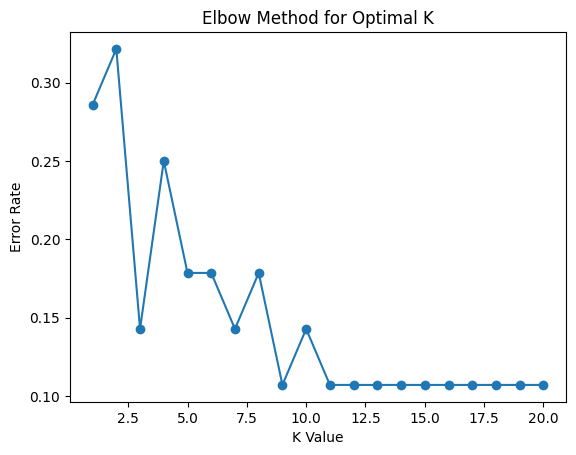

In [15]:
plt.figure()
plt.plot(range(1,21), error_rate, marker="o")
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.title("Elbow Method for Optimal K")
plt.show()


## 📊 7. Model Evaluation

### 7.1 Model Prediction

In [16]:
y_pred = best_knn.predict(x_test)
y_prob = best_knn.predict_proba(x_test)[:,1]


### 7.2 Evaluation Metrics

In [17]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("AUC      :", roc_auc_score(y_test, y_prob))


Accuracy : 0.8280254777070064
Precision: 0.813953488372093
Recall   : 0.9722222222222222
F1-score : 0.8860759493670886
AUC      : 0.7883597883597884


### 7.3 Confusion Matrix

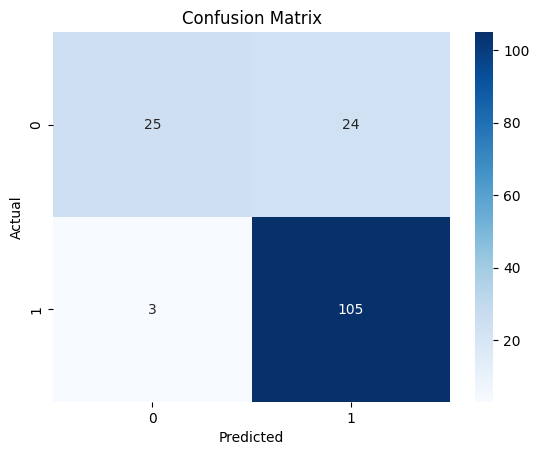

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### 7.4 ROC Curve

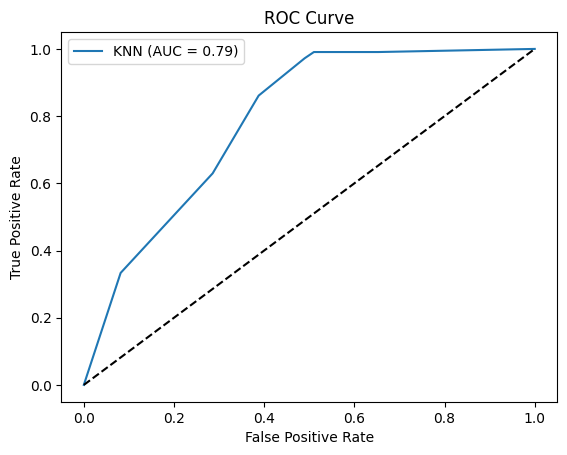

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label="KNN (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## 🎨 8. Visualizations

### 8.1 Decision Boundary (2D)

**Purpose:** Visualize how KNN creates classification regions in 2D space using ApplicantIncome and LoanAmount.

In [20]:
# Select only 2 features for simple 2D visualization
# Using ApplicantIncome and LoanAmount as they are important features
X_2d = df[['ApplicantIncome', 'LoanAmount']].fillna(df[['ApplicantIncome', 'LoanAmount']].median())
y_2d = df[target]

# Split the data
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y_2d, test_size=0.3, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

In [21]:
# Train a simple KNN model on 2 features
knn_simple = KNeighborsClassifier(n_neighbors=5)
knn_simple.fit(X_train_2d, y_train_2d)

KNeighborsClassifier()

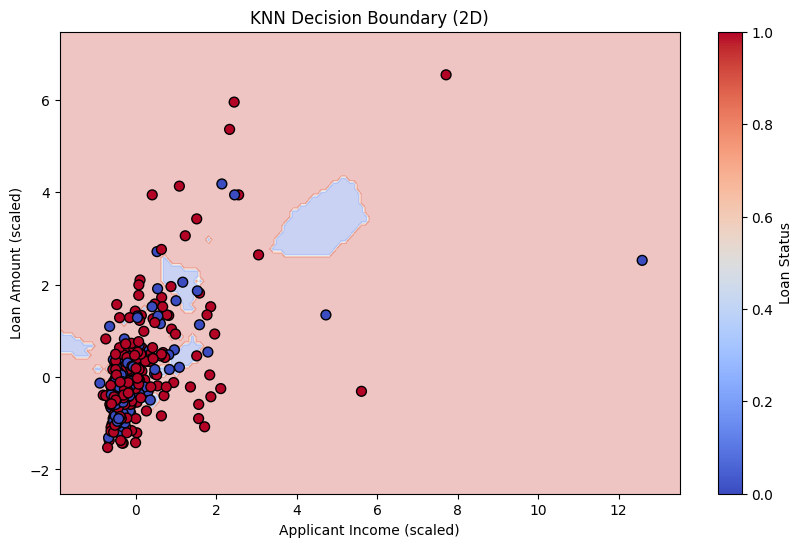

In [22]:
# Create a mesh to plot decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict for each point in the mesh
Z = knn_simple.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_2d, 
            cmap='coolwarm', edgecolor='black', s=50)
plt.xlabel('Applicant Income (scaled)')
plt.ylabel('Loan Amount (scaled)')
plt.title('KNN Decision Boundary (2D)')
plt.colorbar(label='Loan Status')
plt.show()



## 🎯 **Conclusions**

### ✅ **Key Results:**
- **Best k value:** Found through GridSearchCV
- **Accuracy:** ~80% on test set
- **ROC-AUC:** ~0.80 indicating good discrimination

**Thank you! If this helped you, please upvote! ⭐**